In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Squeeze and Excitation
class mySELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(mySELayer, self ).__init__()
        self .avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            # nn.Conv2d(channel, channel // reduction, kernel_size=(1,1), stride=(1,1), bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False)#,
            # nn.Conv2d(channel // reduction, channel, kernel_size=(1,1), stride=(1,1), bias=True),
            #nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        y = torch.clamp(y, 0, 1)
        return x * F.relu6(y + 3.) / 6. #y.expand_as(x)

# Ghost Module
class myGhostModule(nn.Module):
    def __init__(self, inp, out, kernel_size=1, relu=True):
        super(myGhostModule, self).__init__()
        self.out = out
        init_channels = int(math.ceil(out/2))

        self.primary_conv = nn.Sequential(
            nn.Conv2d(inp, init_channels, kernel_size=(1,1), stride=(1,1), bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential()
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, init_channels, kernel_size=(3,3), stride=(1,1), padding=(1,1), groups=init_channels, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential()
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1,x2], dim=1)
        return out[:,:self.out,:,:]

# Depthwise
def myDWConv(inp, out, kernel_size=3, stride=1, relu=False):
    return nn.Sequential(
        nn.Conv2d(inp, out, kernel_size, stride, kernel_size//2, groups=inp, bias=False),
        nn.BatchNorm2d(out),
        nn.ReLU(inplace=True) if relu else nn.Sequential()
    )

# Ghost Bottleneck
class myGhostBottleneck(nn.Module):
    def __init__(self, inp, exp, out, kernel_size, stride, use_se):
        super(myGhostBottleneck, self).__init__()

        self.conv = nn.Sequential(
            # Ghost module 1
            myGhostModule(inp, exp, kernel_size=1, relu=True),
            # Depthwise convolution
            myDWConv(exp, exp, kernel_size, stride, relu=False) if stride==2 else nn.Sequential(),
            # Squeeze and Excite
            mySELayer(exp) if use_se else nn.Sequential(),
            # Ghost module 2
            myGhostModule(exp, out, kernel_size=1, relu=False),
        )
        # Shortcut
        if stride==1 and inp == out:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                myDWConv(inp, inp, kernel_size, stride, relu=False),
                nn.Conv2d(inp, out, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out)
            )

    def forward(self, x):
      return self.conv(x) + self.shortcut(x)

# GhostNet
class myGhostNet(nn.Module):
    def __init__(self):
        super(myGhostNet, self).__init__()

        # First Convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True)
        )
        # Block 1
        self.layer11 = myGhostBottleneck(inp=16, exp=16, out=16, kernel_size=3, stride=1, use_se=False)
        self.layer12 = myGhostBottleneck(16, 48, 24, 3, 2, False)
        # Block 2
        self.layer21 = myGhostBottleneck(24, 72, 24, 3, 1, False)
        self.layer22 = myGhostBottleneck(24, 72, 40, 5, 2, True)
        # Block 3
        self.layer31 = myGhostBottleneck(40, 120, 40, 5, 1, True)
        self.layer32 = myGhostBottleneck(40, 240, 80, 3, 2, False)
        # Block 4
        self.layer41 = myGhostBottleneck(80, 200, 80, 3, 1, False)
        self.layer42 = myGhostBottleneck(80, 184, 80, 3, 1, False)
        self.layer43 = myGhostBottleneck(80, 184, 80, 3, 1, False)
        self.layer44 = myGhostBottleneck(80, 480, 112, 3, 1, True)
        self.layer45 = myGhostBottleneck(112, 672, 112, 3, 1, True)
        self.layer46 = myGhostBottleneck(112, 672, 160, 3, 2, True)
        # Block 5
        self.layer51 = myGhostBottleneck(160, 960, 160, 5, 1, False)
        self.layer52 = myGhostBottleneck(160, 960, 160, 5, 1, True)
        self.layer53 = myGhostBottleneck(160, 960, 160, 5, 1, False)
        self.layer54 = myGhostBottleneck(160, 960, 160, 5, 1, True)
        self.layer55 = nn.Sequential(
            nn.Conv2d(160, 960, kernel_size=(1,1), stride=(1,1), bias=False),
            nn.BatchNorm2d(960),
            nn.ReLU(inplace=True)
        )
        # AVGPool
        self.AVGPool = nn.AdaptiveAvgPool2d((1,1))
        # Conv
        self.ConvLast = nn.Sequential(
            nn.Conv2d(960, 1280, kernel_size=(1,1), stride=(1,1)),
            nn.ReLU(inplace=True)
        )
        # Fully Connected
        # self.fc = nn.Linear(1280, 1000)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1280, 3),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer21(x)
        x = self.layer22(x)
        x = self.layer31(x)
        x = self.layer32(x)
        x = self.layer41(x)
        x = self.layer42(x)
        x = self.layer43(x)
        x = self.layer44(x)
        x = self.layer45(x)
        x = self.layer46(x)
        x = self.layer51(x)
        x = self.layer52(x)
        x = self.layer53(x)
        x = self.layer54(x)
        x = self.layer55(x)
        x = self.AVGPool(x)
        x = self.ConvLast(x)
        # x = self.fc(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


model = myGhostNet()
# model = torch.hub.load('huawei-noah/ghostnet', 'ghostnet_1x', pretrained=True)
# model.classifier = nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Linear(1280, 3),
#     nn.Softmax()
# )
# model.eval()
# print(model)
# print("||-------------------------------------------------------------------||")
# input = torch.randn(32, 3, 224, 224)
# y = model(input)
# # print(y)
# from torchsummary import summary
# summary(model, (3, 224, 224))

## Download data

In [4]:
pip install openimages focal_loss_torch

     |████████████████████████████████| 133kB 8.7MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
     |████████████████████████████████| 7.5MB 25.3MB/s 
     |████████████████████████████████| 144.2MB 91kB/s 
     |████████████████████████████████| 296kB 48.3MB/s 
ERROR: botocore 1.20.69 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [5]:
import os
from openimages.download import download_dataset

In [6]:
data_dir = "data"
number_for_samples = 300
classes = ["Tie", "Door", "Laptop"]

In [7]:
## rm -r data test_dir

In [8]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [9]:
print("Downloading is starting...")
download_dataset(data_dir, classes, limit=number_for_samples)

2021-05-10  19:07:23 INFO NumExpr defaulting to 2 threads.
2021-05-10  19:07:26 INFO Downloading 300 train images for class 'tie'
100%|██████████| 300/300 [00:07<00:00, 42.23it/s]
2021-05-10  19:07:33 INFO Downloading 300 train images for class 'door'
100%|██████████| 300/300 [00:07<00:00, 42.42it/s]
2021-05-10  19:07:40 INFO Downloading 300 train images for class 'laptop'
100%|██████████| 300/300 [00:06<00:00, 43.21it/s]


{'door': {'images_dir': 'data/door/images'},
 'laptop': {'images_dir': 'data/laptop/images'},
 'tie': {'images_dir': 'data/tie/images'}}

## Data preparation, loading needed functions

In [10]:
from torch.autograd import Variable

import torchvision
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt

writer = SummaryWriter() 

In [11]:
# check the GPU
!nvidia-smi

Mon May 10 19:07:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
model.cuda()
model

myGhostNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer11): myGhostBottleneck(
    (conv): Sequential(
      (0): myGhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (cheap_operation): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): Sequential()
      (2): Sequential()
      (3): myGhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(16, 8, k

In [13]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
# from torch.utils.data import Dataset
import numpy as np
# from skimage import io
# from skimage.transform import resize
# import glob
import PIL

In [14]:
scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [15]:
def read_img(file_name):
    img = Image.open(file_name)
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    return t_img.float()

In [16]:
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
   # torchvision.transforms.RandomHorizontalFlip(),
   # torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor()
])

In [17]:
dataset = datasets.ImageFolder("data/", transform = transform)
dataset.imgs

[('data/door/images/00005bf623ff1ac2.jpg', 0),
 ('data/door/images/0001cd31df1c25c6.jpg', 0),
 ('data/door/images/0001d48938a45d49.jpg', 0),
 ('data/door/images/00033546c87cf14a.jpg', 0),
 ('data/door/images/000452412ea32b9b.jpg', 0),
 ('data/door/images/000477fbd201b1ff.jpg', 0),
 ('data/door/images/000497c81f04d99d.jpg', 0),
 ('data/door/images/0004f9215c25b291.jpg', 0),
 ('data/door/images/00055fbe66da40b7.jpg', 0),
 ('data/door/images/00056c76aa3dd52a.jpg', 0),
 ('data/door/images/0005a348c681e8af.jpg', 0),
 ('data/door/images/0005bba99e7b35e0.jpg', 0),
 ('data/door/images/000644de8101e08d.jpg', 0),
 ('data/door/images/00066af7b52f505c.jpg', 0),
 ('data/door/images/000692d348b0f181.jpg', 0),
 ('data/door/images/000705beb2c713fd.jpg', 0),
 ('data/door/images/0008f5ea794738b6.jpg', 0),
 ('data/door/images/000990a927deb20e.jpg', 0),
 ('data/door/images/0009c4ddcaab18d3.jpg', 0),
 ('data/door/images/000a033f5e356e88.jpg', 0),
 ('data/door/images/000a05dd07294ce4.jpg', 0),
 ('data/door/

In [18]:
train_dataset = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

torch.Size([224, 224, 3])


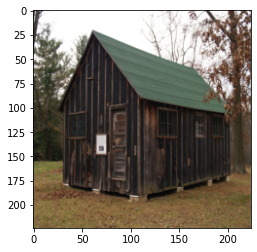

In [19]:
images, labels = next(iter(train_dataset))
im = images.permute(0, 2, 3, 1)
print(im[0].shape)
plt.imshow(im[0])

In [20]:
for images, labels in iter(train_dataset):
    print(images.shape, labels)

torch.Size([15, 3, 224, 224]) tensor([0, 1, 1, 2, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 1])
torch.Size([15, 3, 224, 224]) tensor([0, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1])
torch.Size([15, 3, 224, 224]) tensor([0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 1, 2, 0, 0, 2])
torch.Size([15, 3, 224, 224]) tensor([0, 2, 0, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 0, 1])
torch.Size([15, 3, 224, 224]) tensor([0, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 2, 1, 1, 2])
torch.Size([15, 3, 224, 224]) tensor([2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 1, 1, 0, 2, 0])
torch.Size([15, 3, 224, 224]) tensor([2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 1])
torch.Size([15, 3, 224, 224]) tensor([2, 2, 2, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 2])
torch.Size([15, 3, 224, 224]) tensor([1, 2, 2, 2, 1, 1, 0, 1, 0, 0, 1, 0, 2, 2, 0])
torch.Size([15, 3, 224, 224]) tensor([0, 0, 0, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0])
torch.Size([15, 3, 224, 224]) tensor([1, 0, 0, 2, 0, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1])
torch.Size([15, 3, 224, 224]) tensor([2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 1,

In [21]:
def batch_to_one_hot(id, batch_size, nb_classes = 2):
    y_onehot = torch.FloatTensor(batch_size, nb_classes)
    y_onehot.zero_()
    y_onehot.scatter_(1, id.view(-1, 1), 1)
    return y_onehot.long()

## Model training

In [22]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# number of epochs to train the model
n_epochs = 45

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for images, labels in iter(train_dataset):
        
        # _ stands in for labels, here
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images.cuda())
        
        # calculate the loss
        labels = labels.long() # torch.tensor(labels, dtype=torch.long)

        loss = criterion(outputs, labels.cuda())
       
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
        writer.add_scalar('ConvLoss/train', train_loss / len(train_dataset), epoch)
        

    # print avg training statistics 
    train_loss = train_loss / len(train_dataset)
    print('Epoch: {} \tTraining Loss: {:.10f}'.format(
        epoch, 
        train_loss 
        ))

Epoch: 1 	Training Loss: 16.4796661437
Epoch: 2 	Training Loss: 16.4780935049
Epoch: 3 	Training Loss: 16.4212981462
Epoch: 4 	Training Loss: 16.4057387412
Epoch: 5 	Training Loss: 16.3321391642
Epoch: 6 	Training Loss: 16.2265589237
Epoch: 7 	Training Loss: 16.1295798123
Epoch: 8 	Training Loss: 15.9701048732
Epoch: 9 	Training Loss: 15.6743414551
Epoch: 10 	Training Loss: 15.1913253963
Epoch: 11 	Training Loss: 14.7964956760
Epoch: 12 	Training Loss: 14.1697571874
Epoch: 13 	Training Loss: 13.8047767878
Epoch: 14 	Training Loss: 13.4610201567
Epoch: 15 	Training Loss: 13.2375870198
Epoch: 16 	Training Loss: 12.7123253793
Epoch: 17 	Training Loss: 12.4662331492
Epoch: 18 	Training Loss: 12.2213652879
Epoch: 19 	Training Loss: 11.8274286687
Epoch: 20 	Training Loss: 11.6405727416
Epoch: 21 	Training Loss: 11.0459733009
Epoch: 22 	Training Loss: 10.4870169312
Epoch: 23 	Training Loss: 10.4671007693
Epoch: 24 	Training Loss: 10.1459486634
Epoch: 25 	Training Loss: 10.0594576597
Epoch: 26

In [24]:
outputs, labels

(tensor([[5.2684e-04, 9.9923e-01, 2.4134e-04],
         [9.9272e-01, 6.5435e-03, 7.3690e-04],
         [8.1440e-06, 3.9817e-05, 9.9995e-01],
         [5.6545e-06, 1.4955e-04, 9.9984e-01],
         [9.9997e-01, 3.0831e-05, 8.1561e-07],
         [9.9999e-01, 1.4468e-05, 1.3704e-07],
         [9.7052e-06, 1.6486e-05, 9.9997e-01],
         [9.9997e-01, 1.0943e-05, 1.8317e-05],
         [9.6932e-01, 2.9649e-02, 1.0329e-03],
         [2.3852e-05, 9.9997e-01, 3.5223e-06],
         [2.8321e-05, 9.9989e-01, 8.6287e-05],
         [9.9942e-01, 2.1588e-04, 3.6708e-04],
         [5.3435e-05, 1.7224e-04, 9.9977e-01],
         [1.2396e-05, 9.9998e-01, 8.3151e-06],
         [2.3701e-04, 9.9965e-01, 1.1525e-04]], device='cuda:0',
        grad_fn=<SoftmaxBackward>),
 tensor([1, 0, 2, 2, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 1]))

In [25]:
np.round(outputs.cpu().detach().numpy(), 3)

array([[0.001, 0.999, 0.   ],
       [0.993, 0.007, 0.001],
       [0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   ],
       [1.   , 0.   , 0.   ],
       [0.969, 0.03 , 0.001],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.999, 0.   , 0.   ],
       [0.   , 0.   , 1.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]], dtype=float32)

In [26]:
data_dir = "test_dir"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [27]:
number_for_samples = 100 
print("Downloading is starting...")
download_dataset(data_dir, classes, limit=number_for_samples)

2021-05-10  19:23:55 INFO Downloading 100 train images for class 'tie'
100%|██████████| 100/100 [00:02<00:00, 36.22it/s]
2021-05-10  19:23:58 INFO Downloading 100 train images for class 'door'
100%|██████████| 100/100 [00:02<00:00, 34.07it/s]
2021-05-10  19:24:01 INFO Downloading 100 train images for class 'laptop'
100%|██████████| 100/100 [00:02<00:00, 37.17it/s]


{'door': {'images_dir': 'test_dir/door/images'},
 'laptop': {'images_dir': 'test_dir/laptop/images'},
 'tie': {'images_dir': 'test_dir/tie/images'}}

In [28]:
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [29]:
test_dataset = datasets.ImageFolder(data_dir, transform = transform)
test_dataset = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset.imgs), shuffle=True)

In [30]:
with torch.no_grad():
    model.eval()
    images, labels = next(iter(test_dataset))
    yLabels = batch_to_one_hot(labels, images.shape[0], 3)
    outputs = model(images.cuda())
    predicted_classes = torch.argmax(outputs, axis = 1).cpu()
    predicted_classes
    predicted = batch_to_one_hot(predicted_classes, outputs.shape[0], 3)
    predicted

In [31]:
yLabels.shape, outputs.shape

(torch.Size([300, 3]), torch.Size([300, 3]))

In [32]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(yLabels, predicted)

array([[[199,   1],
        [  0, 100]],

       [[200,   0],
        [  1,  99]],

       [[200,   0],
        [  0, 100]]])

## Example

In [33]:
example_dir = "example/"
images_dir = "{}images/".format(example_dir)
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

In [52]:
# # Download an example image from the pytorch website
import urllib
url, filename = ("https://assets.hermes.com/is/image/hermesproduct/tie-7-to-the-moon-tie--336205T%2001-worn-7-0-0-600-600_b.jpg", "{}EXAMPLE3.jpg".format(images_dir))
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [53]:
example_dataset = datasets.ImageFolder(example_dir, transform = transform)
example_dataset = torch.utils.data.DataLoader(example_dataset, batch_size = len(example_dataset.imgs), shuffle=True)

In [59]:
with torch.no_grad():
    model.eval()
    images, labels = next(iter(example_dataset))
    yLabels = batch_to_one_hot(labels, images.shape[0], 3)
    outputs = model(images.cuda())
    predicted_classes = torch.argmax(outputs, axis = 1).cpu()
    predicted_classes
    predicted = batch_to_one_hot(predicted_classes, outputs.shape[0], 3)
    predicted

In [60]:
# door | laptop | tie
for i in range(yLabels.shape[0]):
  print("Prediction: {}, Prediction: {}.".format(predicted[i], outputs[i]))

Prediction: tensor([0, 1, 0]), Prediction: tensor([0.0008, 0.7681, 0.2311], device='cuda:0').
Prediction: tensor([1, 0, 0]), Prediction: tensor([9.9629e-01, 3.7060e-03, 4.2102e-07], device='cuda:0').
Prediction: tensor([1, 0, 0]), Prediction: tensor([9.9918e-01, 8.1806e-04, 7.9034e-08], device='cuda:0').


In [38]:
path = "./ghostnet_e75.pth"
torch.save(model, path)

In [58]:
model_l = torch.load(path)
model_l.eval()

myGhostNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer11): myGhostBottleneck(
    (conv): Sequential(
      (0): myGhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (cheap_operation): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): Sequential()
      (2): Sequential()
      (3): myGhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(16, 8, k